## Finding Your Way In The City

In this notebook you'll combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

You'll reuse and modify your algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue
import numpy as np
from enum import Enum
import math
#from grid import create_grid
#from planning import a_star

%matplotlib inline

#from bresenham import bresenham

In [2]:
plt.rcParams['figure.figsize'] = 8, 8

In [3]:
class Action(Enum):
    """
    An action is represented by a 3 element tuple.
    
    The first 2 values are the delta of the action relative
    to the current grid position. The third and final value
    is the cost of performing the action.
    """
    LEFT = (0, -1, 1)
    RIGHT = (0, 1, 1)
    UP = (-1, 0, 1)
    DOWN = (1, 0, 1)
    NORTH_EAST = (-1,  1, math.sqrt(2))
    NORTH_WEST = (-1, -1, math.sqrt(2))
    SOUTH_EAST = ( 1,  1, math.sqrt(2))
    SOUTH_WEST = ( 1, -1, math.sqrt(2))    
    
    def __str__(self):
        if self == self.LEFT:
            return '<'
        elif self == self.RIGHT:
            return '>'
        elif self == self.UP:
            return '^'
        elif self == self.DOWN:
            return 'v'
    
    @property
    def cost(self):
        return self.value[2]
    
    @property
    def delta(self):
        return (self.value[0], self.value[1])
            
    
def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and current node.
    """
    valid = [Action.UP, Action.LEFT, Action.RIGHT, Action.DOWN, Action.NORTH_EAST, Action.NORTH_WEST, Action.SOUTH_EAST, Action.SOUTH_WEST]
    n, m = grid.shape[0] - 1, grid.shape[1] - 1
    x, y = current_node
    
    # check if the node is off the grid or
    # it's an obstacle
    
    if x - 1 < 0 or grid[x-1, y] == 1:
        valid.remove(Action.UP)
    if x + 1 > n or grid[x+1, y] == 1:
        valid.remove(Action.DOWN)
    if y - 1 < 0 or grid[x, y-1] == 1:
        valid.remove(Action.LEFT)
    if y + 1 > m or grid[x, y+1] == 1:
        valid.remove(Action.RIGHT)
    
    if x - 1 < 0 or y + 1 > m or grid[x -1, y + 1] == 1:
        valid.remove(Action.NORTH_EAST)
    if x - 1 < 0 or y - 1 < 0 or grid[x - 1, y - 1] == 1:
        valid.remove(Action.NORTH_WEST)
    if x + 1 > n or y + 1 > m or grid[x + 1, y + 1] == 1:
        valid.remove(Action.SOUTH_EAST)
    if x + 1 > n or y - 1 < 0 or grid[x + 1, y - 1] == 1:
        valid.remove(Action.SOUTH_WEST)

    return valid

In [4]:
def create_grid(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    based on given obstacle data, drone altitude and safety distance
    arguments.
    """

    # minimum and maximum north coordinates
    north_min = np.floor(np.amin(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.amax(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.amin(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.amax(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil((north_max - north_min)))
    east_size = int(np.ceil((east_max - east_min)))
    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))
    # Center offset for grid
    north_min_center = np.min(data[:, 0])
    east_min_center = np.min(data[:, 1])
    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]

        # TODO: Determine which cells contain obstacles
        # and set them to 1.
        #
        # Example:
        #
        #    grid[north_coordinate, east_coordinate] = 1
        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(np.clip(north - d_north - safety_distance - north_min, 0, north_size - 1)),
                int(np.clip(north + d_north + safety_distance - north_min, 0, north_size - 1)),
                int(np.clip(east - d_east - safety_distance - east_min, 0, east_size - 1)),
                int(np.clip(east + d_east + safety_distance - east_min, 0, east_size -1))
            ]
            grid[obstacle[0]:obstacle[1] + 1, obstacle[2]:obstacle[3] + 1] = 1

    return grid

In [5]:
def a_star(grid, h, start, goal):

    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for action in valid_actions(grid, current_node):
                # get the tuple representation
                da = action.delta
                cost = action.cost
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                # TODO: calculate new cost, c + g() + h()
                new_cost = current_cost + cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node, action)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, and here you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [6]:
?create_grid

If you would like to alter these implementations, you can modify [grid.py](/edit/grid.py) and [planning.py](/edit/planning.py) in the current directory.

In [7]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [8]:
# Static drone altitude (meters)
drone_altitude = 5

# Minimum distance stay away from obstacle (meters)
safe_distance = 3

In [9]:
# TODO: Use `create_grid` to create a grid configuration space of
# the obstacle data.
grid = create_grid(data, drone_altitude, safe_distance)

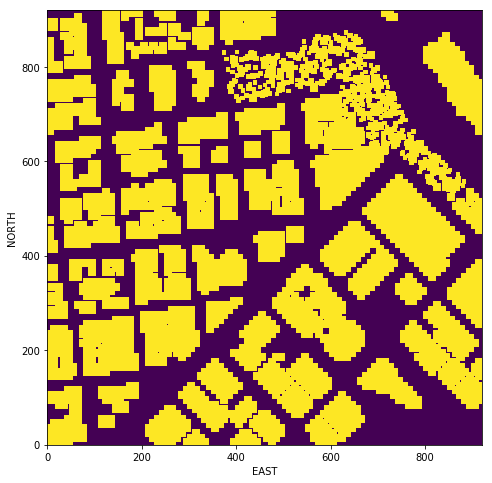

In [10]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Next you'll compute the path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

In [11]:
start_ne = (316, 446)
goal_ne = (787., 46.)

Write a heuristic function.

In [12]:
def heuristic_func(position, goal_position):
    # TODO: write a heuristic!
    return np.abs(position[0] - goal_position[0]) + np.abs(position[1] - goal_position[1])

Compute the lowest cost path with `a_star`. 

In [13]:
# TODO: use `a_star` to compute the lowest cost path
path, cost = a_star(grid, heuristic_func, start_ne, goal_ne)
print(len(path), cost)

Found a path.
649 267902.6366517158


Let's plot the path!

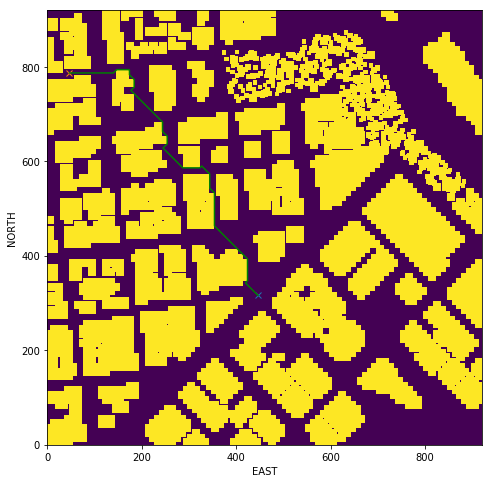

In [14]:
#plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(grid, origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [15]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

Complete the `prune_path` function below. It should return a new path much shorter than the original.

In [16]:
def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i + 1])
        p3 = point(pruned_path[i + 2])
        
        if collinearity_check(p1, p2, p3):
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

Prune the path.

In [17]:
pruned_path = prune_path(path)
print(len(pruned_path))

26


In [18]:
pruned_path

[(316, 446),
 (342, 420),
 (343, 420),
 (347, 424),
 (393, 424),
 (463, 354),
 (533, 354),
 (543, 344),
 (573, 344),
 (590, 327),
 (586, 323),
 (586, 287),
 (628, 245),
 (637, 254),
 (653, 254),
 (663, 244),
 (683, 244),
 (750, 177),
 (757, 184),
 (773, 184),
 (783, 174),
 (793, 174),
 (794, 173),
 (794, 147),
 (787, 140),
 (787, 47)]

Replot the path, it will be the same as before but the drone flight will be much smoother.

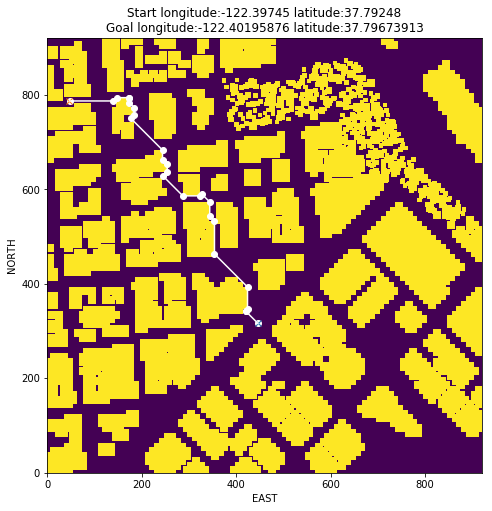

In [19]:
#plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(grid, origin='lower')

plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(pruned_path)
plt.plot(pp[:, 1], pp[:, 0], 'w')
plt.scatter(pp[:, 1], pp[:, 0], c='w')

plt.title('Start longitude:-122.39745 latitude:37.79248\nGoal longitude:-122.40195876 latitude:37.79673913')
plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

Now the waypoints symbolize a change in direction, much better!

0 0


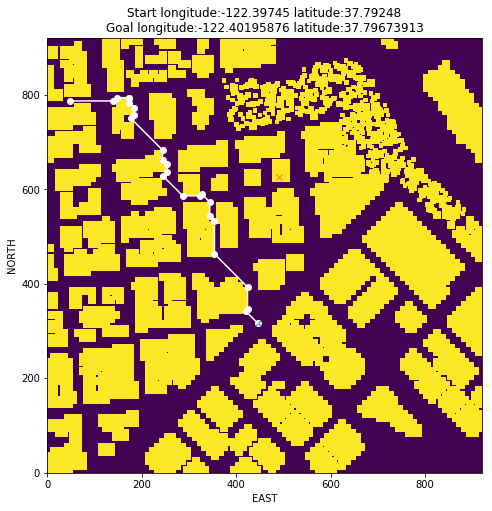

In [20]:
start_ne = (316, 446)
goal_ne = (627., 491.)

path, cost = a_star(grid, heuristic_func, start_ne, goal_ne)
print(len(path), cost)

plt.imshow(grid, origin='lower')

plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(pruned_path)
plt.plot(pp[:, 1], pp[:, 0], 'w')
plt.scatter(pp[:, 1], pp[:, 0], c='w')

plt.title('Start longitude:-122.39745 latitude:37.79248\nGoal longitude:-122.40195876 latitude:37.79673913')
plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()